In [1]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
#building all kinds of evaluating parameters
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix 

In [4]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb # To do our transformation in a unique time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
classifier = RandomForestClassifier

In [5]:
import pandas as pd

url2 = 'Dataset/PRFI_4M_DEF_HEAD.txt'
df = pd.read_table(url2, sep=';')
df.head(5)

,ID_OPER,DT_OP_GMT,ORA_OP_GMT,COD_CANA,COD_CABC,COD_ESITO,PROCESSING_COD,IMP_TRZ_RECON,FL_AUTORIZZAZIONE,COD_ABC_PAES,...,PERC_ESITO_ALL_G,PERC_ESITO_ALL_M,DEV_MEDIA_AUT_SEC_4,DEV_MEDIA_AUT_TO_SEC_4,MEDIA_NON_AUT_SEC_4,MEDIA_NON_AUT_SEC_3,MEDIA_NON_AUT_SEC_2,TIME_NON_AUT_SEC_LAST,ANNO,MESE
0,6231261973,2016-03-14,11:27:28,ATM,6011,0,366100,0.00,T,ITA,...,0.0,0.0,-1.000000,-1.000000,3433466.75,3.764000e+03,5644.5,4498501,2016,3
1,6217512045,2016-03-09,09:48:09,INT,5942,0,6300,9.35,T,ITA,...,0.0,0.0,2.418578,1.092245,1375101.00,1.411049e+06,2070957.5,423982,2016,3
2,6204998318,2016-03-04,12:01:47,INT,5192,0,6300,17.90,T,ITA,...,0.0,0.0,0.864804,2.990299,1375101.00,1.411049e+06,2070957.5,685390,2016,3
3,6260986375,2016-03-25,08:29:03,INT,5968,0,6300,9.99,T,NLD,...,0.0,0.0,-0.279195,-0.279195,1375101.00,1.411049e+06,2070957.5,1377654,2016,3
4,6214969493,2016-03-08,10:36:09,POS,5411,0,0,22.25,T,ITA,...,0.0,0.0,0.306757,-0.103120,1964559.50,2.573075e+06,3425734.0,136317,2016,3


In [6]:
df["FLAG_FRODE"].replace({"T": 1, "F": 0}, inplace=True)

In [7]:
df.pivot_table(values='IMP_TRZ_RECON',index='TIME_ORA_OP',columns='FLAG_FRODE',aggfunc='count')

FLAG_FRODE,0,1
TIME_ORA_OP,,
0,19263,1126
1,12707,967
2,12035,776
3,15269,670
4,35598,810
5,79943,991
6,188506,1170
7,332329,1470
8,440136,1811


In [8]:
def PlotHistogram(df,norm):
    bins = np.arange(df['TIME_ORA_OP'].min(),df['TIME_ORA_OP'].max()+2)
    plt.figure(figsize=(15,4))
    sns.distplot(df[df['FLAG_FRODE']==0]['TIME_ORA_OP'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='b',
                 hist_kws={'alpha':.5},
                 label='Legit')
    sns.distplot(df[df['FLAG_FRODE']==1.0]['TIME_ORA_OP'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='r',
                 label='Fraud',
                 hist_kws={'alpha':.5})
    plt.xticks(range(0,24))
    plt.legend()
    plt.show()

Normalized histogram of Legit/Fraud over hour of the day


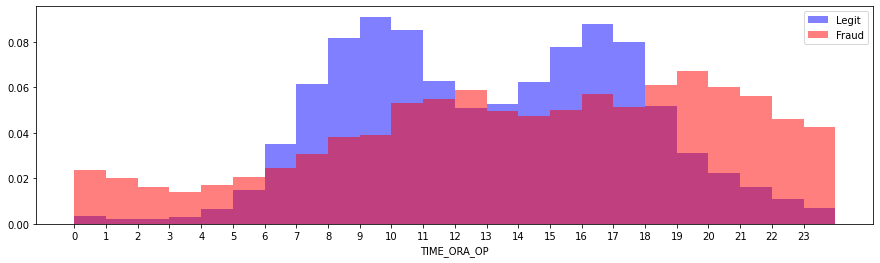

Counts histogram of Legit/Fraud over hour of the day
*you can barely see the Fraud cases since there are so little of them.


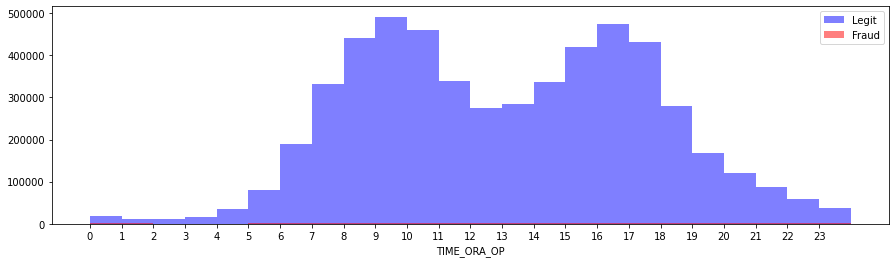

20.670600175857544


In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

start = time.time()
print('Normalized histogram of Legit/Fraud over hour of the day')
PlotHistogram(df,True)
print('Counts histogram of Legit/Fraud over hour of the day')
print('*you can barely see the Fraud cases since there are so little of them.')
PlotHistogram(df,False)
print(time.time()-start)

In [10]:
df["DT_OP_GMT"] = pd.to_datetime(df["DT_OP_GMT"])

start_datetr = '2016-03-01'
end_datetr = '2016-05-31'

start_hr = 10
end_hr = 23
mezzanotte = 0

mask_tr = (df['DT_OP_GMT'] >= start_datetr) & (df['DT_OP_GMT'] < end_datetr) 
df_train = df.loc[mask_tr]

mask_tr = (df_train['TIME_ORA_OP'] >= start_hr) & (df_train['TIME_ORA_OP'] <= end_hr)
df_train = df_train.loc[mask_tr]
print(df_train)

            ID_OPER  DT_OP_GMT ORA_OP_GMT COD_CANA  COD_CABC  COD_ESITO  \
0        6231261973 2016-03-14   11:27:28      ATM      6011          0   
2        6204998318 2016-03-04   12:01:47      INT      5192          0   
4        6214969493 2016-03-08   10:36:09      POS      5411          0   
5        6222279626 2016-03-10   18:57:56      INT      5812          0   
6        6209338514 2016-03-05   19:18:48      POS      5411          0   
...             ...        ...        ...      ...       ...        ...   
5438812  6443141702 2016-05-30   19:07:33      INT      7273          0   
5439277  6442518610 2016-05-30   15:57:05      INT      5045          0   
5439283  6442463929 2016-05-30   17:44:10      INT      8999          0   
5439406  6442771077 2016-05-30   16:54:51      ATM      6011          0   
5439830  6396976594 2016-05-13   17:07:03      ATM      6011          0   

         PROCESSING_COD  IMP_TRZ_RECON FL_AUTORIZZAZIONE COD_ABC_PAES  ...  \
0                3661

In [12]:
start_datevl = '2016-06-14'
end_datevl = '2016-06-22'

start_datets = '2016-06-22'
end_datets = '2016-06-30'

#greater than the start date and smaller than the end date
mask_vl = (df['DT_OP_GMT'] >= start_datevl) & (df['DT_OP_GMT'] < end_datevl)
df_valid = df.loc[mask_vl]

#greater than the start date and smaller than the end date
mask_vl = (df_valid['TIME_ORA_OP'] >= start_hr) & (df_valid['TIME_ORA_OP'] <= end_hr)
df_valid = df_valid.loc[mask_vl]
print(df_valid)

#greater than the start date and smaller than the end date
mask = (df['DT_OP_GMT'] >= start_datets) & (df['DT_OP_GMT'] < end_datets)
df_test = df.loc[mask]

#greater than the start date and smaller than the end date
mask = (df_test['TIME_ORA_OP'] >= start_hr) & (df_test['TIME_ORA_OP'] <= end_hr)
df_test = df_test.loc[mask]
print(df_test)

            ID_OPER  DT_OP_GMT ORA_OP_GMT COD_CANA  COD_CABC  COD_ESITO  \
47       6490500262 2016-06-16   11:20:09      ATM      6011          0   
48       6491527622 2016-06-16   16:48:17      POS      5411          0   
50       6489132049 2016-06-15   21:23:07      INT      5735          0   
51       6491520771 2016-06-16   16:46:36      POS      5411          0   
54       6489139644 2016-06-15   21:32:28      INT      5735          0   
...             ...        ...        ...      ...       ...        ...   
5442898  6497225417 2016-06-18   15:55:39      ATM      6011          0   
5442901  6497210707 2016-06-18   15:51:41      ATM      5550          0   
5442902  6499220800 2016-06-19   15:28:30      ATM      6011          0   
5442903  6497533879 2016-06-18   17:15:33      ATM      5550          0   
5442904  6497533290 2016-06-18   17:15:30      ATM      5550          0   

         PROCESSING_COD  IMP_TRZ_RECON FL_AUTORIZZAZIONE COD_ABC_PAES  ...  \
47                161

In [13]:
df_train = df_train[['ID_OPER', 'DT_OP_GMT', 'ORA_OP_GMT', 'COD_CANA', 'COD_CABC',
                'PROCESSING_COD', 'IMP_TRZ_RECON', 'FL_AUTORIZZAZIONE',
                'COD_ABC_PAES', 'ID_TIPO_CARTA', 'TIPO_INPUT_MODE',
                'COD_CIRC', 'FLAG_FRODE', 'TRX_TYPE', 'Row_Num', 'TIME_ORA_OP','DEV_MEDIA_IMP_TC_1M','PERC_RISK_CIRC_TC_TO_1M',
               'DEV_MEDIA_IMP_CAN_1M','DEV_MEDIA_IMP_TO_1M','PERC_OPER_NON_AUTOR_1M','PERC_OPER_NON_AUTOR_2M','MEDIA_NON_AUT_SEC_4',
               'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M','FLAG_IMP_PREC_0','TREND_3_5','FLAG_CAMBIO_PAESE_AUT',
               'FLAG_CAMBIO_PAESE_NON_AUT','PERC_ESITO_NSF_G','PERC_ESITO_CV2_G',
               'PERC_ESITO_PIN_G','PERC_ESITO_SCUDO_G','PERC_ESITO_DT_SCAD_G','PERC_ESITO_ALTRO_G',
               'DEV_MEDIA_AUT_SEC_4']]

In [16]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df_train['IMP_TRZ_RECON_NORM'] = rob_scaler.fit_transform(df_train['IMP_TRZ_RECON'].values.reshape(-1,1)) 

df_train.drop(['IMP_TRZ_RECON'], axis=1, inplace=True)

Come abbiamo detto prima, ci sono diversi modi per ricampionare i dati distorti. Oltre al sottocampionamento e al sovracampionamento, c'è un approccio molto popolare chiamato SMOTE (Synthetic Minority Over-Sampling Technique), che è una combinazione di sovracampionamento e sottocampionamento, ma l'approccio di sovracampionamento non consiste nel replicare la classe di minoranza
ma costruendo una nuova istanza di dati della classe di minoranza tramite un algoritmo.

Il modo in cui sotto-campioneremo il set di dati sarà quello di creare un rapporto 50/50. Questo sarà fatto selezionando casualmente "x", quantità di campione dalla classe di maggioranza, essendo "x" il numero totale di record con la classe di minoranza.


In [17]:
# Number of data points in the minority class
df_train = df_train.reset_index()
number_records_fraud = len(df_train[df_train.FLAG_FRODE == 1])
fraud_indices = np.array(df_train[df_train.FLAG_FRODE == 1].index)

In [18]:
# Picking the indices of the normal classes
normal_indices = df_train[df_train.FLAG_FRODE == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dfset
df_train_undersample = df_train.iloc[under_sample_indices,:]

#X_undersample = under_sample_df.loc[:, under_sample_df.columns != 'FLAG_FRODE']
#y_undersample = under_sample_df.loc[:, under_sample_df.columns == 'FLAG_FRODE']
df_train_undersample

,index,ID_OPER,DT_OP_GMT,ORA_OP_GMT,COD_CANA,COD_CABC,PROCESSING_COD,FL_AUTORIZZAZIONE,COD_ABC_PAES,ID_TIPO_CARTA,...,FLAG_CAMBIO_PAESE_AUT,FLAG_CAMBIO_PAESE_NON_AUT,PERC_ESITO_NSF_G,PERC_ESITO_CV2_G,PERC_ESITO_PIN_G,PERC_ESITO_SCUDO_G,PERC_ESITO_DT_SCAD_G,PERC_ESITO_ALTRO_G,DEV_MEDIA_AUT_SEC_4,IMP_TRZ_RECON_NORM
26,40,6251120205,2016-03-21,16:55:41,INT,5968,0,T,GBR,1028,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.061449,-0.179118
45,71,6277642583,2016-03-31,19:43:54,INT,5499,6300,T,GBR,1028,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.039607,-0.361765
142,211,6197611312,2016-03-01,19:47:39,INT,5968,0,T,GBR,1028,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,-0.059709,-0.258235
162,243,6208432253,2016-03-05,14:45:15,INT,5968,0,T,LUX,1028,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.187753,-0.082500
177,262,6226346809,2016-03-12,10:24:17,INT,5968,6300,T,GBR,1028,...,0,1,0.0,0.0,0.0,0.0,0.0,0.0,-0.768935,-0.361765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938484,5014719,6377410067,2016-05-06,17:51:12,ATM,6011,16100,T,ITA,1063,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,285.314313,-0.082353
1562786,2691016,6434943772,2016-05-27,16:19:06,ATM,6011,16100,T,ITA,1063,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354157,-0.082353
506119,855360,6349964776,2016-04-27,14:42:25,POS,7230,0,T,ITA,1017,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.840023,0.211765
341682,563967,6274652116,2016-03-30,17:53:17,ATM,5554,276100,T,ITA,1017,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.479385,5.520588


In [19]:
# Normalizziamo la variabile importo

rob_scaler = RobustScaler()

df_valid['IMP_TRZ_RECON_NORM'] = rob_scaler.fit_transform(df_valid['IMP_TRZ_RECON'].values.reshape(-1,1)) 

df_valid.drop(['IMP_TRZ_RECON'], axis=1, inplace=True)

In [20]:
# Normalizziamo la variabile importo

rob_scaler = RobustScaler()

df_test['IMP_TRZ_RECON_NORM'] = rob_scaler.fit_transform(df_test['IMP_TRZ_RECON'].values.reshape(-1,1)) 

df_test.drop(['IMP_TRZ_RECON'], axis=1, inplace=True)

In [24]:
#separating the X and the Y values
    
xTrain = df_train_undersample[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON_NORM']]

xValid = df_valid[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON_NORM']]

xTest = df_test[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON_NORM']]

yTrain = df_train_undersample["FLAG_FRODE"]

yValid = df_valid["FLAG_FRODE"]

yTest = df_test["FLAG_FRODE"]

In [28]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,6,8],
    'max_features': [2,3],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(xTrain, yTrain)
grid_search.best_params_

In [171]:
#For XGB
# Make predictions on validation dataset
XGB = XGBClassifier(random_state=0,n_jobs=-1,max_depth = 11,
 min_child_weight = 5,
 eta = 0.01,
 subsample= 1.0,
 colsample_bytree =  1.0,
 objective = 'reg:squarederror')

XGB.fit(xTrain,yTrain)
predictions_xgb = XGB.predict(xTest)
print(accuracy_score(yTest, predictions_xgb))
print(confusion_matrix(yTest, predictions_xgb))
print(classification_report(yTest, predictions_xgb))

0.8264666960741067
[[18615  3915]
 [   19   121]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     22530
           1       0.03      0.86      0.06       140

    accuracy                           0.83     22670
   macro avg       0.51      0.85      0.48     22670
weighted avg       0.99      0.83      0.90     22670



In [81]:
#building the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 
#random forest model creation 
rfc = RandomForestClassifier(random_state=0,n_jobs=-1)
rfc.fit(xTrain,yTrain)
yPred = rfc.predict(xTest)
print(accuracy_score(yTest, yPred))
print(confusion_matrix(yTest, yPred))
print(classification_report(yTest, yPred))

0.8322011468901632
[[18739  3791]
 [   13   127]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     22530
           1       0.03      0.91      0.06       140

    accuracy                           0.83     22670
   macro avg       0.52      0.87      0.49     22670
weighted avg       0.99      0.83      0.90     22670



In [82]:
from sklearn.ensemble import AdaBoostClassifier
adab = AdaBoostClassifier(n_estimators=100, random_state=0)
adab.fit(xTrain,yTrain)
yPred = adab.predict(xTest)
print(accuracy_score(yTest, yPred))
print(confusion_matrix(yTest, yPred))
print(classification_report(yTest, yPred))

0.8406263784737539
[[18947  3583]
 [   30   110]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     22530
           1       0.03      0.79      0.06       140

    accuracy                           0.84     22670
   macro avg       0.51      0.81      0.49     22670
weighted avg       0.99      0.84      0.91     22670



In [83]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [40]:
df["DT_OP_GMT"] = pd.to_datetime(df["DT_OP_GMT"])

start_datetr = '2016-03-01'
end_datetr = '2016-05-31'

start_hr = 0
end_hr = 10

mask_tr = (df['DT_OP_GMT'] >= start_datetr) & (df['DT_OP_GMT'] < end_datetr) 
df_train = df.loc[mask_tr]

mask_tr = (df_train['TIME_ORA_OP'] >= start_hr) & (df_train['TIME_ORA_OP'] <= end_hr)
df_train = df_train.loc[mask_tr]
print(df_train)

            ID_OPER  DT_OP_GMT ORA_OP_GMT COD_CANA  COD_CABC  COD_ESITO  \
1        6217512045 2016-03-09   09:48:09      INT      5942          0   
3        6260986375 2016-03-25   08:29:03      INT      5968          0   
4        6214969493 2016-03-08   10:36:09      POS      5411          0   
7        6233723975 2016-03-15   09:55:14      POS      5411          0   
10       6228819867 2016-03-13   10:02:40      POS      5912          0   
...             ...        ...        ...      ...       ...        ...   
5437120  6441468987 2016-05-30   10:06:43      ATM      5550          0   
5437273  6441468847 2016-05-30   10:06:45      ATM      5550          0   
5437480  6441570095 2016-05-30   10:33:53      POS      4900          0   
5437548  6441583498 2016-05-30   10:37:43      POS      4900          0   
5437550  6441559912 2016-05-30   10:31:01      POS      4900          0   

         PROCESSING_COD  IMP_TRZ_RECON FL_AUTORIZZAZIONE COD_ABC_PAES  ...  \
1                  63

In [41]:
start_datets = '2016-06-15'
end_datets = '2016-06-22'

#greater than the start date and smaller than the end date
mask = (df['DT_OP_GMT'] >= start_datets) & (df['DT_OP_GMT'] < end_datets)
df_test = df.loc[mask]

#greater than the start date and smaller than the end date
mask = (df_test['TIME_ORA_OP'] >= start_hr) & (df_test['TIME_ORA_OP'] <= end_hr)
df_test = df_test.loc[mask]
print(df_test)

            ID_OPER  DT_OP_GMT ORA_OP_GMT COD_CANA  COD_CABC  COD_ESITO  \
632      6500461920 2016-06-20   08:32:45      INT      5499          0   
1130     6489958646 2016-06-16   09:04:46      INT      5999          0   
1427     6493205138 2016-06-17   10:10:27      POS      5691          0   
1442     6493072563 2016-06-17   09:39:21      POS      5411          0   
1720     6486132355 2016-06-15   01:06:59      INT      4899          0   
...             ...        ...        ...      ...       ...        ...   
5442854  6496169805 2016-06-18   09:56:04      ATM      5550          0   
5442865  6496240268 2016-06-18   10:10:22      ATM      5550          0   
5442866  6496240175 2016-06-18   10:10:19      ATM      5550          0   
5442867  6496354923 2016-06-18   10:35:36      ATM      5550          0   
5442886  6500080280 2016-06-20   08:36:36      INT      4812          0   

         PROCESSING_COD  IMP_TRZ_RECON FL_AUTORIZZAZIONE COD_ABC_PAES  ...  \
632                63

In [42]:
df_train = df_train[['ID_OPER', 'DT_OP_GMT', 'ORA_OP_GMT', 'COD_CANA', 'COD_CABC',
                'PROCESSING_COD', 'IMP_TRZ_RECON', 'FL_AUTORIZZAZIONE',
                'COD_ABC_PAES', 'ID_TIPO_CARTA', 'TIPO_INPUT_MODE',
                'COD_CIRC', 'FLAG_FRODE', 'TRX_TYPE', 'Row_Num', 'TIME_ORA_OP','DEV_MEDIA_IMP_TC_1M','PERC_RISK_CIRC_TC_TO_1M',
               'DEV_MEDIA_IMP_CAN_1M','DEV_MEDIA_IMP_TO_1M','PERC_OPER_NON_AUTOR_1M','PERC_OPER_NON_AUTOR_2M','MEDIA_NON_AUT_SEC_4',
               'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M','FLAG_IMP_PREC_0','TREND_3_5','FLAG_CAMBIO_PAESE_AUT',
               'FLAG_CAMBIO_PAESE_NON_AUT','PERC_ESITO_NSF_G','PERC_ESITO_CV2_G',
               'PERC_ESITO_PIN_G','PERC_ESITO_SCUDO_G','PERC_ESITO_DT_SCAD_G','PERC_ESITO_ALTRO_G',
               'DEV_MEDIA_AUT_SEC_4']]

In [43]:
# Number of data points in the minority class
df_train = df_train.reset_index()
number_records_fraud = len(df_train[df_train.FLAG_FRODE == 1])
fraud_indices = np.array(df_train[df_train.FLAG_FRODE == 1].index)

In [44]:
# Picking the indices of the normal classes
normal_indices = df_train[df_train.FLAG_FRODE == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dfset
df_train_undersample = df_train.iloc[under_sample_indices,:]

#X_undersample = under_sample_df.loc[:, under_sample_df.columns != 'FLAG_FRODE']
#y_undersample = under_sample_df.loc[:, under_sample_df.columns == 'FLAG_FRODE']
df_train_undersample

,index,ID_OPER,DT_OP_GMT,ORA_OP_GMT,COD_CANA,COD_CABC,PROCESSING_COD,IMP_TRZ_RECON,FL_AUTORIZZAZIONE,COD_ABC_PAES,...,TREND_3_5,FLAG_CAMBIO_PAESE_AUT,FLAG_CAMBIO_PAESE_NON_AUT,PERC_ESITO_NSF_G,PERC_ESITO_CV2_G,PERC_ESITO_PIN_G,PERC_ESITO_SCUDO_G,PERC_ESITO_DT_SCAD_G,PERC_ESITO_ALTRO_G,DEV_MEDIA_AUT_SEC_4
16,38,6226002651,2016-03-12,09:16:37,INT,7399,360000,0.00,T,BMU,...,1.081081,1,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000
37,112,6197847455,2016-03-02,01:47:32,INT,7995,116300,100.00,T,MLT,...,0.000000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2052.826531
38,113,6197847677,2016-03-02,01:46:43,INT,7995,116300,100.00,T,MLT,...,0.000000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1057.342105
90,262,6226346809,2016-03-12,10:24:17,INT,5968,6300,1.00,T,GBR,...,0.607226,0,1,0.0,0.0,0.0,0.0,0.0,0.0,-0.768935
153,492,6297689184,2016-04-08,02:07:47,INT,7995,116300,120.00,T,GBR,...,1.166159,1,0,0.5,0.0,0.0,0.5,0.0,0.0,-0.819013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536275,1643867,6339640307,2016-04-23,10:04:55,POS,5411,0,60.44,T,ITA,...,1.068813,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.725561
123863,413267,6372373533,2016-05-05,07:55:00,POS,4900,16200,500.00,T,ITA,...,1.086957,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.373987
1542398,4901879,6311353928,2016-04-13,07:07:02,ATM,6011,16100,20.00,T,ITA,...,1.349380,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.373021
307512,958656,6284952669,2016-04-03,07:49:59,POS,4112,0,84.60,T,ITA,...,1.409782,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.758514


In [45]:
#separating the X and the Y values
    
xTrain = df_train_undersample[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON']]

xTest = df_test[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON']]

yTrain = df_train_undersample["FLAG_FRODE"]

yTest = df_test["FLAG_FRODE"]

In [46]:
#For XGB
# Make predictions on validation dataset
XGB = XGBClassifier(random_state=0,n_jobs=-1)
XGB.fit(xTrain,yTrain)
predictions_xgb = XGB.predict(xTest)
print(accuracy_score(yTest, predictions_xgb))
print(confusion_matrix(yTest, predictions_xgb))
print(classification_report(yTest, predictions_xgb))

c:\users\fap91\pycharmprojects\tesitirocinio\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8859850292778897
[[75709  9756]
 [   38   398]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     85465
           1       0.04      0.91      0.08       436

    accuracy                           0.89     85901
   macro avg       0.52      0.90      0.51     85901
weighted avg       0.99      0.89      0.93     85901



In [58]:
df["DT_OP_GMT"] = pd.to_datetime(df["DT_OP_GMT"])

start_datetr = '2016-03-01'
end_datetr = '2016-03-15'

start_hr = 10
end_hr = 23
mezzanotte = 0

mask_tr = (df['DT_OP_GMT'] >= start_datetr) & (df['DT_OP_GMT'] < end_datetr) 
df_train = df.loc[mask_tr]

mask_tr = (df_train['TIME_ORA_OP'] >= start_hr) & (df_train['TIME_ORA_OP'] <= end_hr)
df_train = df_train.loc[mask_tr]
print(df_train)

            ID_OPER  DT_OP_GMT ORA_OP_GMT COD_CANA  COD_CABC  COD_ESITO  \
0        6231261973 2016-03-14   11:27:28      ATM      6011          0   
2        6204998318 2016-03-04   12:01:47      INT      5192          0   
4        6214969493 2016-03-08   10:36:09      POS      5411          0   
5        6222279626 2016-03-10   18:57:56      INT      5812          0   
6        6209338514 2016-03-05   19:18:48      POS      5411          0   
...             ...        ...        ...      ...       ...        ...   
5230512  6231391942 2016-03-14   12:04:36      ATM      5550          0   
5230565  6231409080 2016-03-14   12:10:07      ATM      5550          0   
5230579  6231412991 2016-03-14   12:11:16      ATM      6011          0   
5230661  6231409397 2016-03-14   12:10:08      ATM      5550          0   
5231188  6231615016 2016-03-14   13:32:37      ATM      6011          0   

         PROCESSING_COD  IMP_TRZ_RECON FL_AUTORIZZAZIONE COD_ABC_PAES  ...  \
0                3661

In [59]:
start_datets = '2016-06-15'
end_datets = '2016-06-16'

#greater than the start date and smaller than the end date
mask = (df['DT_OP_GMT'] >= start_datets) & (df['DT_OP_GMT'] < end_datets)
df_test = df.loc[mask]

#greater than the start date and smaller than the end date
mask = (df_test['TIME_ORA_OP'] >= start_hr) & (df_test['TIME_ORA_OP'] <= end_hr)
df_test = df_test.loc[mask]
print(df_test)

            ID_OPER  DT_OP_GMT ORA_OP_GMT COD_CANA  COD_CABC  COD_ESITO  \
50       6489132049 2016-06-15   21:23:07      INT      5735          0   
54       6489139644 2016-06-15   21:32:28      INT      5735          0   
717      6488504186 2016-06-15   16:40:01      INT      5999          0   
1445     6488011217 2016-06-15   14:40:20      POS      5411          0   
3759     6487555050 2016-06-15   11:52:03      POS      5411          0   
...             ...        ...        ...      ...       ...        ...   
5442252  6487906303 2016-06-15   14:07:35      INT      5691          0   
5442313  6488697894 2016-06-15   17:25:10      ATM      6011          0   
5442315  6488693679 2016-06-15   17:24:02      ATM      6011          0   
5442391  6488508609 2016-06-15   16:41:00      ATM      5550          0   
5442393  6488620418 2016-06-15   17:06:10      POS      5411          0   

         PROCESSING_COD  IMP_TRZ_RECON FL_AUTORIZZAZIONE COD_ABC_PAES  ...  \
50                 63

In [66]:
xTrain = df_train[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON']]

xTest = df_test[['TIME_ORA_OP','ID_TIPO_CARTA','DEV_MEDIA_IMP_TC_1M', 'PERC_RISK_CIRC_TC_TO_1M',
       'DEV_MEDIA_IMP_CAN_1M', 'DEV_MEDIA_IMP_TO_1M', 'PERC_OPER_NON_AUTOR_1M',
       'PERC_OPER_NON_AUTOR_2M', 'MEDIA_NON_AUT_SEC_4',
       'DEV_IMP_MEDIA_ULTIME_3', 'PERC_RISK_MCC_1M', 'FLAG_IMP_PREC_0',
       'TREND_3_5','FLAG_CAMBIO_PAESE_NON_AUT',
       'PERC_ESITO_NSF_G', 'PERC_ESITO_CV2_G', 'PERC_ESITO_PIN_G',
       'PERC_ESITO_SCUDO_G', 'PERC_ESITO_DT_SCAD_G', 'PERC_ESITO_ALTRO_G',
       'DEV_MEDIA_AUT_SEC_4','IMP_TRZ_RECON']]

yTrain = df_train["FLAG_FRODE"]

yTest = df_test["FLAG_FRODE"]

In [67]:
XGB = XGBClassifier(random_state=0,n_jobs=-1)
XGB.fit(xTrain,yTrain)
predictions_xgb = XGB.predict(xTest)
print(accuracy_score(yTest, predictions_xgb))
print(confusion_matrix(yTest, predictions_xgb))
print(classification_report(yTest, predictions_xgb))

[17:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9932509925011028
[[22512    18]
 [  135     5]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22530
           1       0.22      0.04      0.06       140

    accuracy                           0.99     22670
   macro avg       0.61      0.52      0.53     22670
weighted avg       0.99      0.99      0.99     22670



Text(0.5, 1.0, 'Balanced Correlation Matrix')

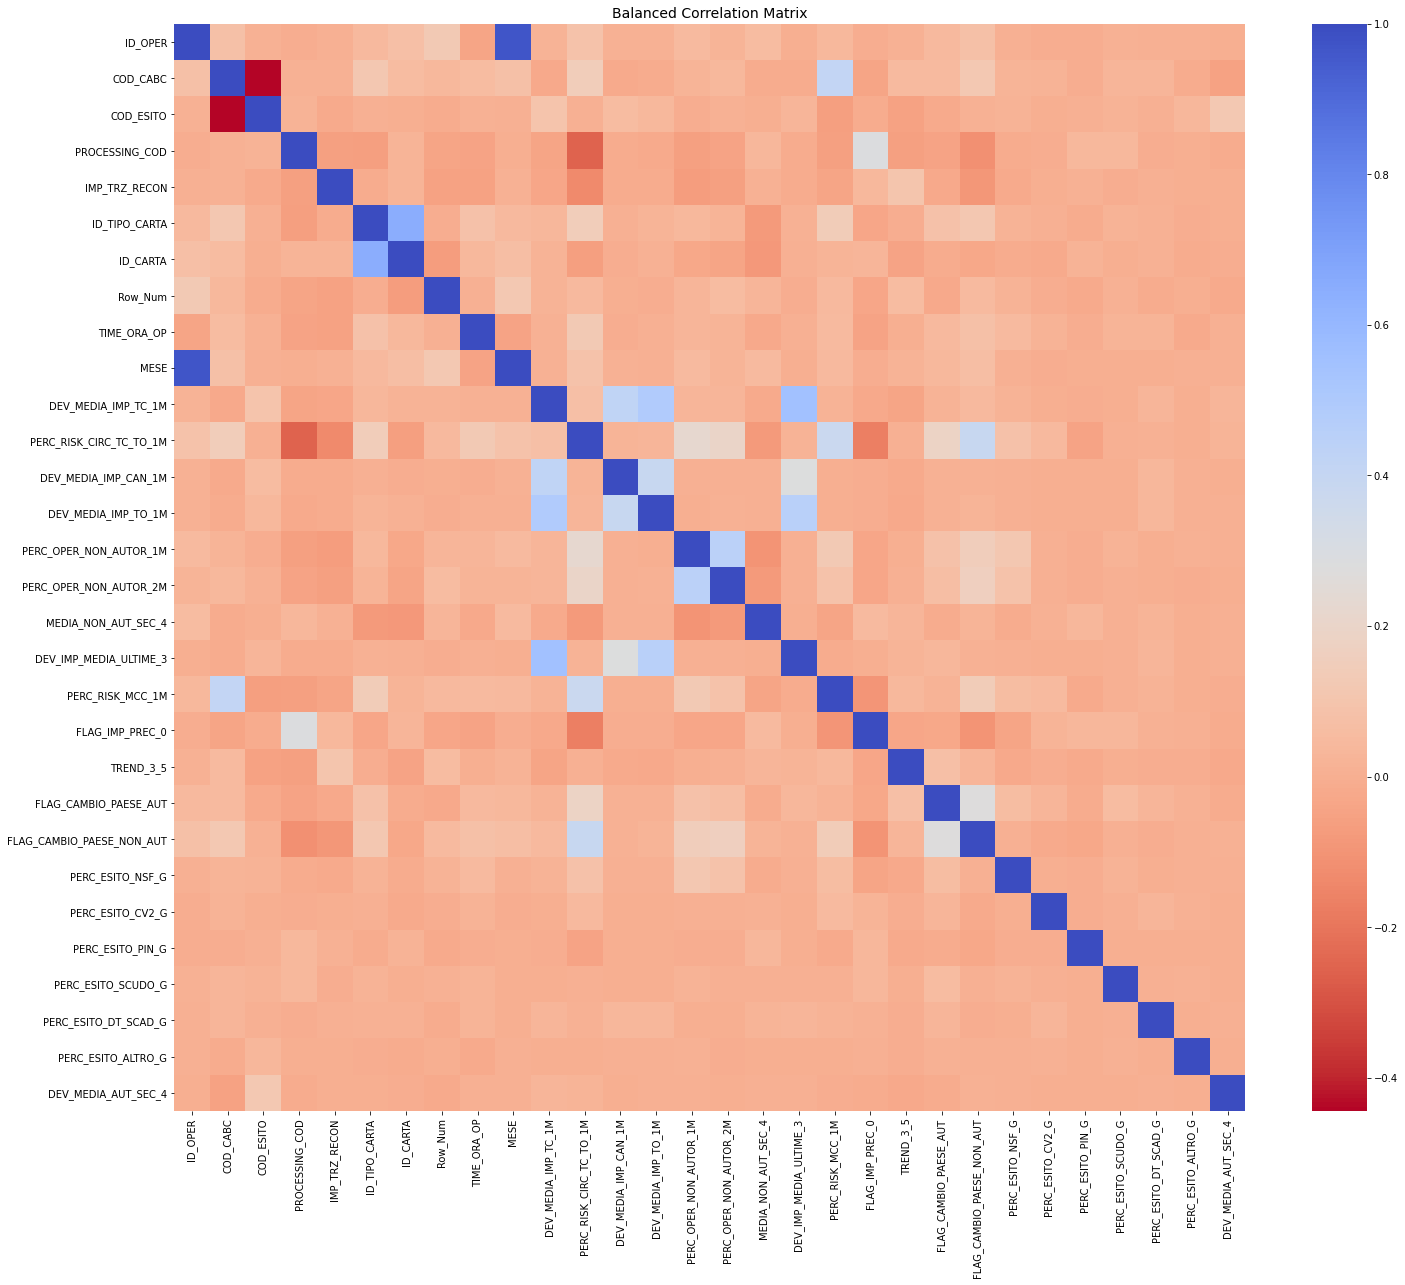

In [198]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))

# Entire DataFrame
corr = under_sample_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', ax=ax1)
ax1.set_title("Balanced Correlation Matrix", fontsize=14)

In [199]:
under_sample_df["FLAG_FRODE"].replace({"T": 1, "F": 0}, inplace=True)

c:\users\fap91\pycharmprojects\tesitirocinio\venv\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [200]:
for c in under_sample_df:
    print ("---- %s ---" % c)
    print (under_sample_df[c].value_counts())

---- ID_OPER ---
6375473152    1
6428495243    1
6276027258    1
6241516949    1
6211492971    1
             ..
6313657037    1
6208117421    1
6400488512    1
6209600202    1
6368661502    1
Name: ID_OPER, Length: 95324, dtype: int64
---- DT_OP_GMT ---
2016-03-01    1271
2016-03-22    1265
2016-06-30    1153
2016-03-05    1128
2016-03-23    1122
              ... 
2016-06-26     419
2016-06-18     403
2016-06-05     402
2016-06-12     390
2016-06-19     388
Name: DT_OP_GMT, Length: 122, dtype: int64
---- ORA_OP_GMT ---
18:20:18    11
16:43:24    10
10:50:28    10
17:36:15    10
17:54:33     9
            ..
18:04:46     1
09:21:08     1
06:58:22     1
14:56:44     1
00:06:08     1
Name: ORA_OP_GMT, Length: 52063, dtype: int64
---- COD_CANA ---
INT    54152
POS    19936
ATM    19287
I3D      864
VPO      479
PPI      351
BPO       99
APP       93
PDP       33
PTM       28
MBP        2
Name: COD_CANA, dtype: int64
---- COD_CABC ---
6011    13996
5734     7945
7995     6294
5411     602

In [201]:
data = spark.createDataFrame(under_sample_df)

In [202]:

classFreq = data.groupBy("FLAG_FRODE").count()
classFreq.show()
toPlot = classFreq.toPandas()

+----------+-----+
|FLAG_FRODE|count|
+----------+-----+
|         0|47662|
|         1|47662|
+----------+-----+



#### Conversione i valori in double


In [203]:
for column in data.columns:
    data = data.withColumn(column,data[column].cast("double"))

In [204]:
data.columns

['ID_OPER',
 'DT_OP_GMT',
 'ORA_OP_GMT',
 'COD_CANA',
 'COD_CABC',
 'COD_ESITO',
 'PROCESSING_COD',
 'IMP_TRZ_RECON',
 'FL_AUTORIZZAZIONE',
 'COD_ABC_PAES',
 'ID_TIPO_CARTA',
 'ID_CARTA',
 'TIPO_INPUT_MODE',
 'COD_CIRC',
 'FLAG_FRODE',
 'TRX_TYPE',
 'Row_Num',
 'TIME_ORA_OP',
 'MESE',
 'DEV_MEDIA_IMP_TC_1M',
 'PERC_RISK_CIRC_TC_TO_1M',
 'DEV_MEDIA_IMP_CAN_1M',
 'DEV_MEDIA_IMP_TO_1M',
 'PERC_OPER_NON_AUTOR_1M',
 'PERC_OPER_NON_AUTOR_2M',
 'MEDIA_NON_AUT_SEC_4',
 'DEV_IMP_MEDIA_ULTIME_3',
 'PERC_RISK_MCC_1M',
 'FLAG_IMP_PREC_0',
 'TREND_3_5',
 'FLAG_CAMBIO_PAESE_AUT',
 'FLAG_CAMBIO_PAESE_NON_AUT',
 'PERC_ESITO_NSF_G',
 'PERC_ESITO_CV2_G',
 'PERC_ESITO_PIN_G',
 'PERC_ESITO_SCUDO_G',
 'PERC_ESITO_DT_SCAD_G',
 'PERC_ESITO_ALTRO_G',
 'DEV_MEDIA_AUT_SEC_4']

#### Adding index to keep track of the rows even after shuffling

In [205]:
from pyspark.sql.window import Window
win = Window().orderBy('TIME_ORA_OP')
data = data.withColumn("idx", row_number().over(win))

#### Importing required Spark ML lib methods

In [206]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

#### Converting the feature columns to dense vector (required by spark) and  creating label and index columns

In [207]:
data.columns

['ID_OPER',
 'DT_OP_GMT',
 'ORA_OP_GMT',
 'COD_CANA',
 'COD_CABC',
 'COD_ESITO',
 'PROCESSING_COD',
 'IMP_TRZ_RECON',
 'FL_AUTORIZZAZIONE',
 'COD_ABC_PAES',
 'ID_TIPO_CARTA',
 'ID_CARTA',
 'TIPO_INPUT_MODE',
 'COD_CIRC',
 'FLAG_FRODE',
 'TRX_TYPE',
 'Row_Num',
 'TIME_ORA_OP',
 'MESE',
 'DEV_MEDIA_IMP_TC_1M',
 'PERC_RISK_CIRC_TC_TO_1M',
 'DEV_MEDIA_IMP_CAN_1M',
 'DEV_MEDIA_IMP_TO_1M',
 'PERC_OPER_NON_AUTOR_1M',
 'PERC_OPER_NON_AUTOR_2M',
 'MEDIA_NON_AUT_SEC_4',
 'DEV_IMP_MEDIA_ULTIME_3',
 'PERC_RISK_MCC_1M',
 'FLAG_IMP_PREC_0',
 'TREND_3_5',
 'FLAG_CAMBIO_PAESE_AUT',
 'FLAG_CAMBIO_PAESE_NON_AUT',
 'PERC_ESITO_NSF_G',
 'PERC_ESITO_CV2_G',
 'PERC_ESITO_PIN_G',
 'PERC_ESITO_SCUDO_G',
 'PERC_ESITO_DT_SCAD_G',
 'PERC_ESITO_ALTRO_G',
 'DEV_MEDIA_AUT_SEC_4',
 'idx']

In [208]:
training_df = data.rdd.map(lambda x: (DenseVector(x[19:38]),x[14],x[39]))

In [209]:
training_df = spark.createDataFrame(training_df,["features","label","index"])


In [210]:
training_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[0.434603,0.00141...|  1.0|    1|
|[-0.858652,0.0999...|  1.0|    2|
|[-0.174047,0.2310...|  1.0|    3|
|[-0.669567,0.2310...|  1.0|    4|
|[-0.449293,0.2310...|  1.0|    5|
|[7.497878,0.23100...|  1.0|    6|
|[0.414423,0.23100...|  1.0|    7|
|[4.66147,0.231007...|  1.0|    8|
|[0.060641,0.23100...|  1.0|    9|
|[7.480883,0.23100...|  1.0|   10|
|[7.799983,0.20784...|  1.0|   11|
|[1.195596,0.20784...|  1.0|   12|
|[1.120221,0.09997...|  1.0|   13|
|[0.30885,0.033765...|  1.0|   14|
|[0.00447,0.25113,...|  1.0|   15|
|[0.686828,4.04E-4...|  1.0|   16|
|[0.842068,0.23100...|  1.0|   17|
|[-0.152081,0.2310...|  1.0|   18|
|[0.374395,0.20784...|  1.0|   19|
|[2.245522,0.20784...|  1.0|   20|
+--------------------+-----+-----+
only showing top 20 rows



In [211]:
training_df = training_df.select("index","features","label")
training_df.show()

+-----+--------------------+-----+
|index|            features|label|
+-----+--------------------+-----+
|    1|[0.434603,0.00141...|  1.0|
|    2|[-0.858652,0.0999...|  1.0|
|    3|[-0.174047,0.2310...|  1.0|
|    4|[-0.669567,0.2310...|  1.0|
|    5|[-0.449293,0.2310...|  1.0|
|    6|[7.497878,0.23100...|  1.0|
|    7|[0.414423,0.23100...|  1.0|
|    8|[4.66147,0.231007...|  1.0|
|    9|[0.060641,0.23100...|  1.0|
|   10|[7.480883,0.23100...|  1.0|
|   11|[7.799983,0.20784...|  1.0|
|   12|[1.195596,0.20784...|  1.0|
|   13|[1.120221,0.09997...|  1.0|
|   14|[0.30885,0.033765...|  1.0|
|   15|[0.00447,0.25113,...|  1.0|
|   16|[0.686828,4.04E-4...|  1.0|
|   17|[0.842068,0.23100...|  1.0|
|   18|[-0.152081,0.2310...|  1.0|
|   19|[0.374395,0.20784...|  1.0|
|   20|[2.245522,0.20784...|  1.0|
+-----+--------------------+-----+
only showing top 20 rows



#### Splitting data into training and testing data

In [212]:
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [213]:
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|38158|
|  1.0|38197|
+-----+-----+



In [214]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 9504|
|  1.0| 9465|
+-----+-----+



#### Creating Gradient Boosting Trees Classifier Model to fit and predict data

Gradient boosting (traducibile in italiano come: "potenziamento del gradiente") è una tecnica di machine learning di regressione e problemi di Classificazione statistica che producono un modello predittivo nella forma di un insieme di modelli predittivi deboli, tipicamente alberi di decisione. Costruisce un modello in maniera simile ai metodi di boosting, e li generalizza permettendo l'ottimizzazione di una funzione di perdita differenziabile arbitraria.

Il boosting è una tecnica di machine learning che rientra nella categoria dell'Apprendimento ensemble. Nel boosting più modelli vengono generati consecutivamente dando sempre più peso agli errori effettuati nei modelli precedenti. In questo modo si creano modelli via via più "attenti" agli aspetti che hanno causato inesattezze nei modelli precedenti, ottenendo infine un modello aggregato avente migliore accuratezza di ciascun modello che lo costituisce

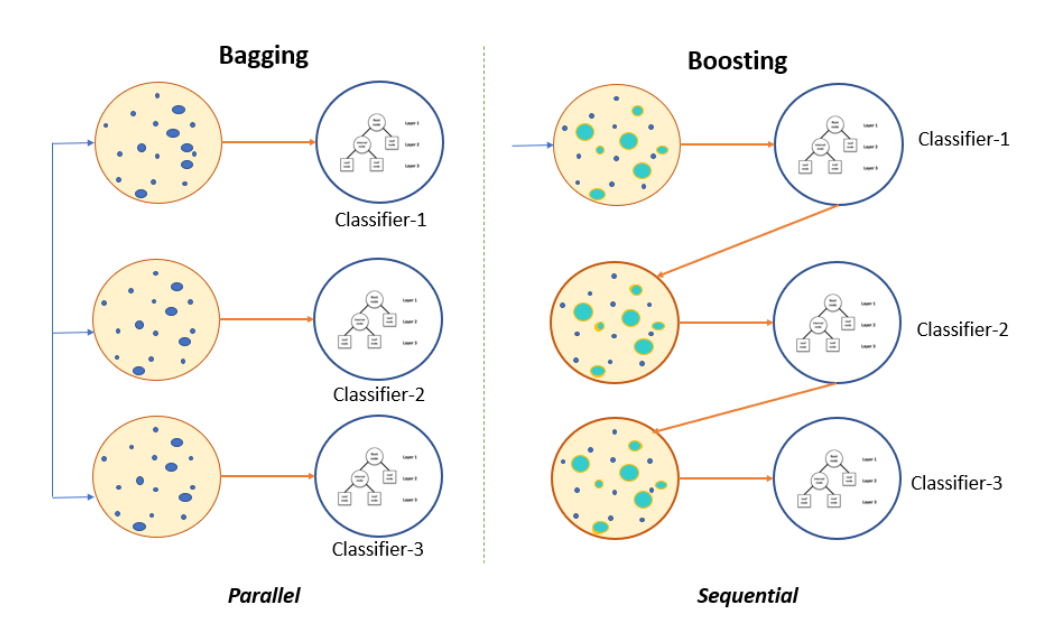

Bagging — Bootstrap Aggregation or Bagging is a ML algorithm in which a number of independent predictors are built by taking samples with replacement. The individual outcomes are then combined by average (Regression) or majority voting (Classification) to derive the final prediction. A widely used algorithm in this space is Random Forest.

Boosting — Boosting is a ML algorithm in which the weak learners are converted into strong learners. Weak learners are classifiers which always perform slightly better than chance irrespective of the distribution over the training data. In Boosting, the predictions are sequential wherein each subsequent predictor learns from the errors of the previous predictors. Gradient Boosting Trees (GBT) is a commonly used method in this category.



This method is sensitive to outliers. Outliers will have much larger residuals than non-outliers, so gradient boosting will focus a disproportionate amount of its attention on those points.

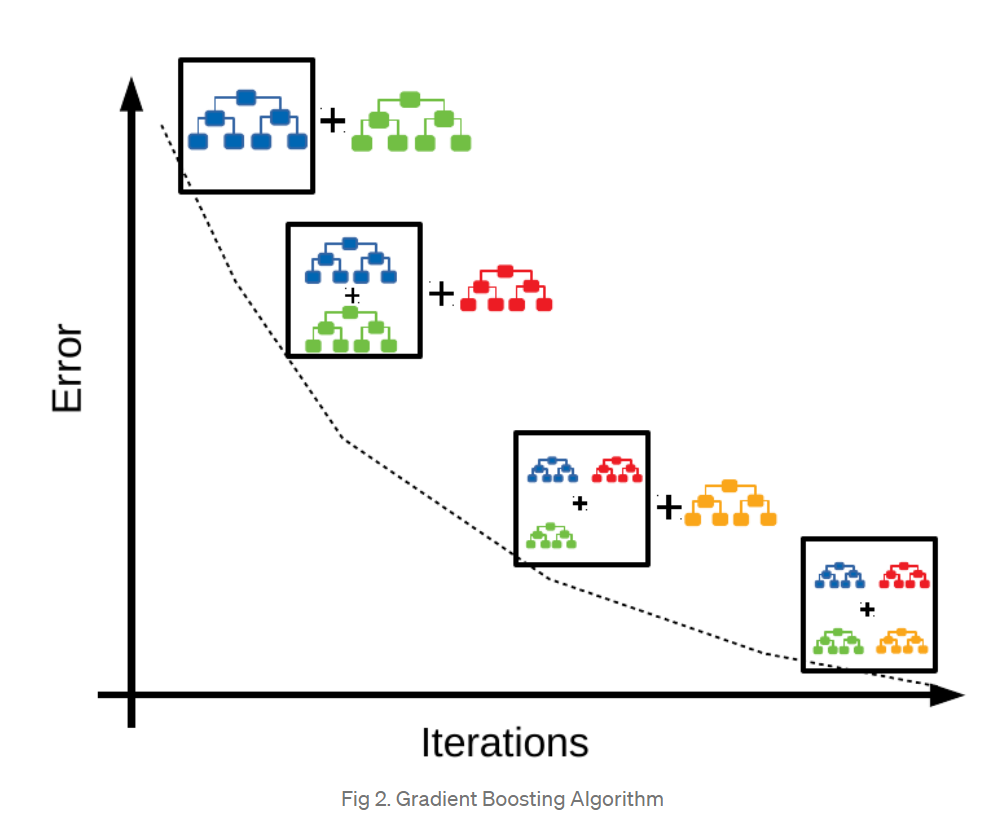

In [215]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)

In [216]:
model = gbt.fit(train_data)

In [1]:
predictions = model.transform(test_data)

NameError: name 'model' is not defined

#### Checking the count of records classified into each classes

In [218]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 8868|
|       1.0|10101|
+----------+-----+



#### Calculating accuracy of model

In [219]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.968966123864104

#### Calculating percentage of fraud records predicted correctly

In [220]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [221]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1| 8934|
|              0|10035|
+---------------+-----+



In [222]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 9504|
|  1.0| 9465|
+-----+-----+



In [223]:
from pyspark.sql.functions import col

In [224]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

In [225]:
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
totalFraud

9465

In [226]:
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

In [227]:
FraudPredictionAccuracy

94.38985736925515

#### Calculating Confusion matrix

In [228]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

In [229]:
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

In [230]:
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

In [231]:
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [232]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  8934 
True Negative:  8337 
False Positive:  1167 
False Negative:  531


### Recall

In [233]:
print("Recall: ",tp/(tp+fn))

Recall:  0.9438985736925515


### Precision

In [234]:
print("Precision: ", tp/(tp+fp))




Precision:  0.8844668844668845


In [235]:
 print("F1 Score: " ,tp/(tp+((fn+fp)/2)))

F1 Score:  0.9132168046611469
